<a href="https://colab.research.google.com/github/danil99152/prediction-of-government-tenders/blob/main/auction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [1]:
!pip install catboost

     |████████████████████████████████| 69.2MB 46kB/s 


In [2]:
from datetime import datetime, date
import math
import re
import gc

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sbs
from statsmodels.graphics.mosaicplot import mosaic


from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import RMSprop
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint
from keras.models import load_model

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb
import catboost as ctb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
# from lightgbm import LGBMClassifier

import joblib
import pickle

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!gdown --id 1L6BffI4zO8ZMOtTOle3XABOXQ-5ZcfTU

Downloading...
From: https://drive.google.com/uc?id=1L6BffI4zO8ZMOtTOle3XABOXQ-5ZcfTU
To: /content/purchase_plans.csv
5.52MB [00:00, 48.5MB/s]


#Обработка данных

Считывание данных о заявках

In [13]:
contract_path = 'purchase_plans.csv'
dtypes = {'plan_number' : 'category', 
          'positionNumber' : 'category', 
          'customer_legal_form' : 'category', 
          'KTRU' : 'category',
          'publicDiscussion' : 'category',
          'isEnergyServiceContract': 'category'}
data = pd.read_csv(contract_path, dtype = dtypes)
gc.collect()
data.head()

,plan_number,customer_legal_form,positionNumber,positionCanceled,publicDiscussion,total,isEnergyServiceContract,time,OKPD,log_total
0,201801133000253003,75404,201801133000253003000150,False,false,97522.23,false,44,95.12.10.000,11.487836
1,201901133000089001,75404,201901133000089001000001,True,false,195000.00,false,31,35.11.10.000,12.180755
2,201901133000074001,75404,201901133000074001000001,False,false,3117.87,false,365,19.20.21.125,8.044905
3,201901133000089001,75404,201901133000089001000016,False,false,16000.00,false,365,61.10.11.110,9.680344
4,201901133000089001,75404,201901133000089001000001,True,false,195000.00,false,31,35.11.10.000,12.180755


In [37]:
num_var = ['total', 'time']
cat_var = ['plan_number', 
          'positionNumber', 
          'customer_legal_form', 
          'publicDiscussion',
          'isEnergyServiceContract',
           'OKPD']

#Анализ

In [ ]:
data.corr()

,total,time
total,1.000000,0.026131
time,0.026131,1.000000


Описание цены

In [ ]:
data['total'].describe()

count    4.920400e+04
mean     3.033807e+06
std      1.161167e+08
min      1.000000e-02
25%      2.800000e+04
50%      8.756000e+04
75%      2.999925e+05
max      7.154803e+09
Name: total, dtype: float64

In [ ]:
# Мода, медиана, среднее
result = {'mode': [], 'median': [], 'mean': []}
for nv in num_var:
    result['mode'].append(int(data[nv].mode()[0]))
    result['median'].append(int(data[nv].median()))
    result['mean'].append(int(data[nv].mean()))

result = pd.DataFrame(result, index=num_var)
result = result[['mode', 'median', 'mean']]
result

,mode,median,mean
total,50000,87560,3033806
time,365,258,255


In [ ]:
OKOPF = {
    '10000' : 'Юридические лица - коммерческие корпоративные организации',
    '11000' : 'Хозяйственные товарищества',
    '11051' : 'Полные товарищества',
    '11064' : 'Товарищества на вере (коммандитные товарищества)',
    '12000' : 'Хозяйственные общества',
    '12200' : 'Акционерные общества',
    '12247' : 'Публичные акционерные общества',
    '12267' : 'Непубличные акционерные общества',
    '12300' : 'Общества с ограниченной ответственностью',
    '13000' : 'Хозяйственные партнерства',
    '14000' : 'Производственные кооперативы (артели)',
    '14100' : 'Сельскохозяйственные производственные кооперативы',
    '14153' : 'Сельскохозяйственные артели (колхозы)',
    '14154' : 'Рыболовецкие артели (колхозы)',
    '14155' : 'Кооперативные хозяйства (коопхозы)',
    '14200' : 'Производственные кооперативы',
    '15300' : 'Крестьянские (фермерские) хозяйства',
    '19000' : 'Юридические лица - прочие коммерческие организации',
    '20000' : 'Юридические лица - некоммерческие корпоративные организации',
    '20100' : 'Потребительские кооперативы',
    '20101' : 'Гаражные и гаражно-строительные кооперативы',
    '20102' : 'Жилищные или жилищно-строительные кооперативы',
    '20103' : 'Жилищные накопительные кооперативы',
    '20104' : 'Кредитные потребительские кооперативы',
    '20105' : 'Кредитные потребительские кооперативы граждан',
    '20106' : 'Кредитные кооперативы второго уровня',
    '20107' : 'Потребительские общества',
    '20108' : 'Общества взаимного страхования',
    '20109' : 'Сельскохозяйственные потребительские перерабатывающие кооперативы',
    '20110' : 'Сельскохозяйственные потребительские сбытовые (торговые) кооперативы',
    '20111' : 'Сельскохозяйственные потребительские обслуживающие кооперативы',
    '20112' : 'Сельскохозяйственные потребительские снабженческие кооперативы',
    '20113' : 'Объединения фермерских хозяйств',
    '20115' : 'Сельскохозяйственные потребительские животноводческие кооперативы',
    '20121' : 'Фонды проката',
    '20200' : 'Общественные организации',
    '20201' : 'Политические партии',
    '20202' : 'Профсоюзные организации',
    '20210' : 'Общественные движения',
    '20211' : 'Органы общественной самодеятельности',
    '20217' : 'Территориальные общественные самоуправления',
    '20600' : 'Ассоциации (союзы)',
    '20601' : 'Ассоциации (союзы) экономического взаимодействия субъектов Российской Федерации',
    '20603' : 'Советы муниципальных образований субъектов РФ',
    '20604' : 'Союзы (ассоциации) кредитных кооперативов',
    '20605' : 'Союзы (ассоциации) кооперативов',
    '20606' : 'Союзы (ассоциации) общественных объединений',
    '20608' : 'Союзы потребительских обществ',
    '20609' : 'Адвокатские палаты',
    '20610' : 'Нотариальные палаты',
    '20611' : 'Торгово-промышленные палаты',
    '20612' : 'Объединения работодателей',
    '20613' : 'Объединения фермерских хозяйств',
    '20614' : 'Некоммерческие партнерства',
    '20615' : 'Адвокатские бюро',
    '20616' : 'Коллегии адвокатов',
    '20619' : 'Саморегулируемые организации',
    '20620' : 'Объединения (ассоциации и союзы) благотворительных организаций',
    '20700' : 'Товарищества собственников недвижимости',
    '20702' : 'Садоводческие или огороднические некоммерческие товарищества',
    '20716' : 'Товарищества собственников жилья',
    '20900' : 'Учреждения',
    '21100' : 'Казачьи общества',
    '21200' : 'Общины коренных малочисленных народов РФ',
    '30000' : 'Организации без прав юридического лица',
    '30001' : 'Представительства юридических лиц',
    '30002' : 'Филиалы юридических лиц',
    '30003' : 'Обособленные подразделения юридических лиц',
    '30004' : 'Структурные подразделения обособленных подразделений юридических лиц',
    '30005' : 'Паевые инвестиционные фонды',
    '30006' : 'Простые товарищества',
    '30008' : 'Районные суды, городские суды, межрайонные суды (районные суды)',
    '40000' : 'Международные организации на территории РФ',
    '40001' : 'Межправительственные международные организации',
    '40002' : 'Неправительственные международные организации',
    '50000' : 'Физическое лицо',
    '50100' : 'Организационно-правовые формы для коммерческой деятельности граждан',
    '50101' : 'Главы крестьянских (фермерских) хозяйств',
    '50102' : 'Индивидуальные предприниматели',
    '50200' : 'Организационно-правовые формы для деятельности граждан, не отнесенной к предпринимательству',
    '50201' : 'Адвокаты, учредившие адвокатский кабинет',
    '50202' : 'Нотариусы, занимающиеся частной практикой',
    '60000' : 'Юридические лица - коммерческие унитарные организации',
    '65000' : 'Унитарные предприятия',
    '65100' : 'Казенные предприятия',
    '65141' : 'Федеральные казенные предприятия',
    '65142' : 'Казенные предприятия субъектов РФ',
    '65143' : 'Муниципальные казенные предприятия',
    '65200' : 'Унитарные предприятия, основанные на праве хозяйственного ведения',
    '65241' : 'Федеральные государственные унитарные предприятия',
    '65242' : 'Государственные унитарные предприятия субъектов РФ',
    '65243' : 'Муниципальные унитарные предприятия',
    '70000' : 'Юридические лица - некоммерческие унитарные организации',
    '70400' : 'Фонды',
    '70401' : 'Благотворительные фонды',
    '70402' : 'Негосударственные пенсионные фонды',
    '70403' : 'Общественные фонды',
    '70404' : 'Экологические фонды',
    '71400' : 'Автономные некоммерческие организации',
    '71500' : 'Религиозные организации',
    '71600' : 'Публично-правовые компании',
    '71601' : 'Государственные корпорации',
    '71602' : 'Государственные компании',
    '71610' : 'Отделения иностранных некоммерческих неправительственных организаций',
    '75000' : 'Учреждения',
    '75100' : 'Учреждения, созданные Российской Федерацией',
    '75101' : 'Федеральные государственные автономные учреждения',
    '75103' : 'Федеральные государственные бюджетные учреждения',
    '75104' : 'Федеральные государственные казенные учреждения',
    '75200' : 'Учреждения, созданные субъектом РФ',
    '75201' : 'Государственные автономные учреждения субъектов РФ',
    '75203' : 'Государственные бюджетные учреждения субъектов РФ',
    '75204' : 'Государственные казенные учреждения субъектов РФ',
    '75300' : 'Государственные академии наук',
    '75400' : 'Муниципальные учреждения',
    '75401' : 'Муниципальные автономные учреждения',
    '75403' : 'Муниципальные бюджетные учреждения',
    '75404' : 'Муниципальные казенные учреждения',
    '75500' : 'Частные учреждения',
    '75502' : 'Благотворительные учреждения',
    '75505' : 'Общественные учреждения',
}

In [ ]:
def OKOPF_sub(x):
  return f"({x}) {OKOPF[x]}"

10251

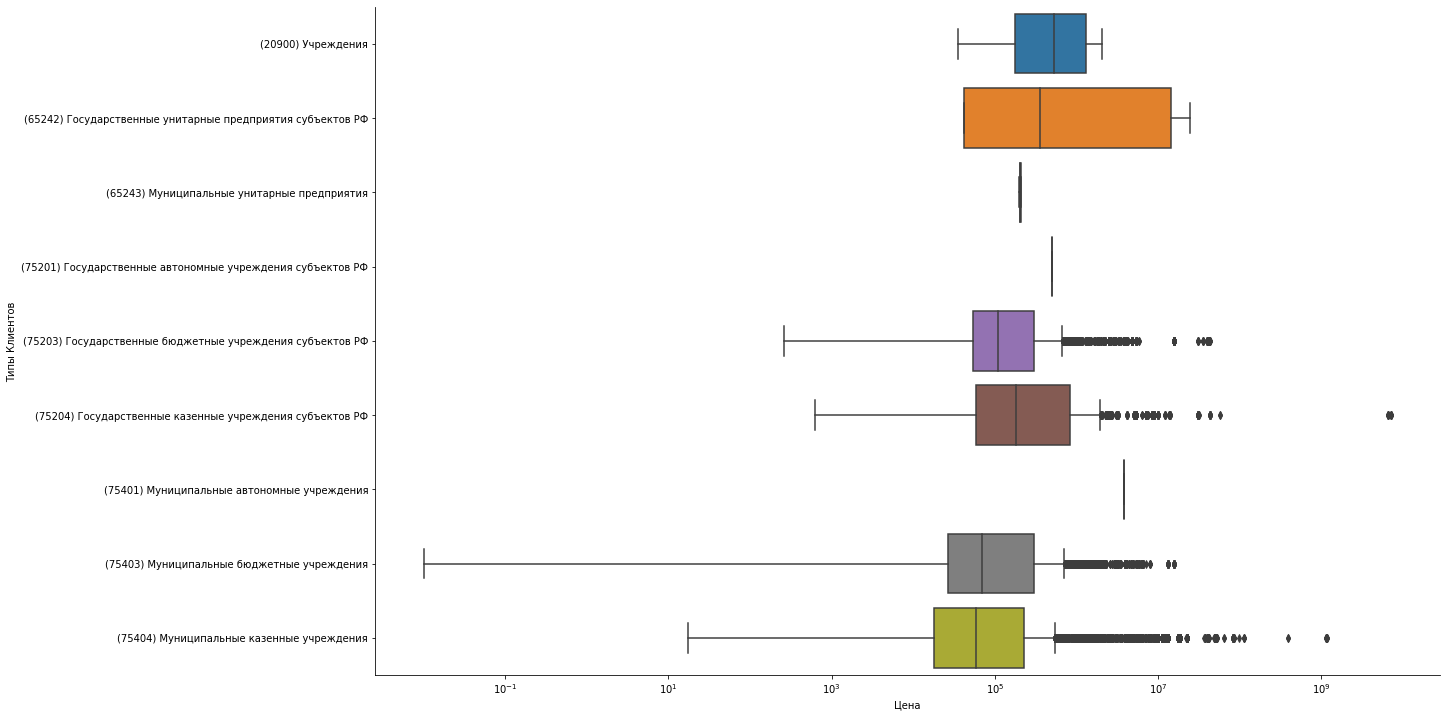

In [ ]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['customer_legal_form', 'total'], axis=1).sort_values('customer_legal_form')
  data_to_plot['customer_legal_form'] = data_to_plot['customer_legal_form'].map(OKOPF_sub)
  g = sbs.catplot(y = 'customer_legal_form', x = 'total', kind ='box', height = 10, aspect = 2, data = data_to_plot, orient = 'h')
  g.set(xscale = 'log', xlabel = 'Цена', ylabel = 'Типы Клиентов')
  
del data_to_plot
del g
gc.collect()

Цена и продолжительность

9889

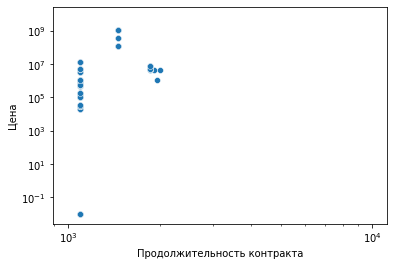

In [ ]:
g = sbs.scatterplot(x = 'time', y = 'total', data = data)
g.set(xscale = 'log', yscale = 'log', xlabel = 'Продолжительность контракта', ylabel = 'Цена')

del g
gc.collect()

1975

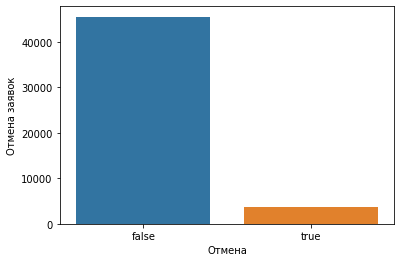

In [ ]:
g = sbs.countplot(x = 'positionCanceled', data = data)
g.set(xlabel = 'Отмена', ylabel = 'Отмена заявок')

del g
gc.collect()

Время и отмена

2058

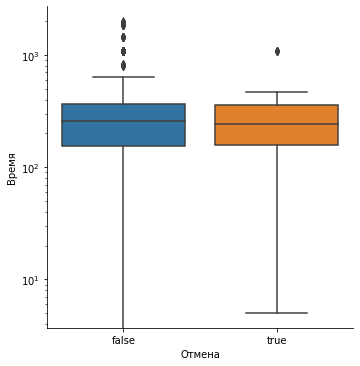

In [ ]:
g = sbs.catplot(x = 'positionCanceled', y = 'time', kind ='box', aspect = 1, data = data)
g.set(yscale = 'log', xlabel = 'Отмена', ylabel = 'Время')

del g
gc.collect()

Цена и отмена

8479

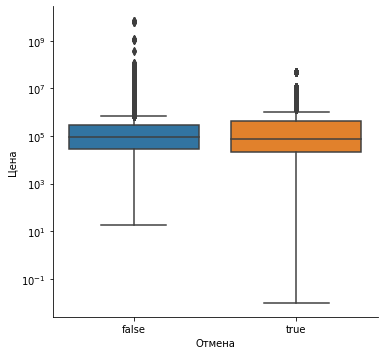

In [ ]:
g = sbs.catplot(x = 'positionCanceled', y = 'total', kind ='box', aspect = 1, data = data)
g.set(yscale = 'log', xlabel = 'Отмена', ylabel = 'Цена')

del g
gc.collect()

#Прогноз отмены

In [15]:
#Балансировка данных
old_indexes = round(len(data[data['positionCanceled']==False])
 - len(data[data['positionCanceled']==True]))
data.sort_values('positionCanceled', inplace = True)
data = data.reset_index()
data.drop(data[((data.index < old_indexes) & (data['positionCanceled']==False))].index, inplace=True)
data.sort_values('index', inplace = True)
data = data.drop(['index'], axis=1)
data = data.reset_index(drop=True)
gc.collect()

In [25]:
print("True", len(data[data['positionCanceled']==True]))
print("False", len(data[data['positionCanceled']==False]))

True 3671
False 3671


In [27]:
data_True = data[data['positionCanceled']==True]
data_True = data_True.reset_index(drop=True)
data_False = data[data['positionCanceled']==False]
data_False = data_False.reset_index(drop=True)

In [38]:
x_True = data_True.drop(['positionCanceled', 'total', 'log_total'], axis=1)
y_True = data_True['positionCanceled']

x_False = data_False.drop(['positionCanceled', 'total', 'log_total'], axis=1)
y_False = data_False['positionCanceled']

gc.collect()

219

In [90]:
x_train_True, x_test_True, y_train_True, y_test_True = train_test_split(x_True, y_True, test_size=0.2, shuffle = False)
x_train_False, x_test_False, y_train_False, y_test_False = train_test_split(x_False, y_False, test_size=0.2, shuffle = False)

In [91]:
percent = 0.5 #% разницы между тренировочными True и False
droped = round(len(y_train_True)*percent)
x_train_False.drop(x_train_False[x_train_False.index < droped].index, inplace=True)
x_train_False = x_train_False.reset_index(drop=True)
y_train_False.drop(y_train_False[y_train_False.index < droped].index, inplace=True)
y_train_False = y_train_False.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [92]:
x_train = pd.concat([x_train_False, x_train_True])
y_train = pd.concat([y_train_False, y_train_True])
x_test = pd.concat([x_test_False, x_test_True])
y_test = pd.concat([y_test_False, y_test_True])

In [93]:
print('True', len(y_train[y_train == True].index))
print('False', len(y_train[y_train == False].index))
print("Разница в трен данных:", 1 - len(y_train[y_train == False].index)/len(y_train[y_train == True].index))

True 2936
False 1468
Разница в трен данных: 0.5


In [94]:
print('True', len(y_test[y_test == True].index))
print('False', len(y_test[y_test == False].index))

True 735
False 735


In [95]:
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

Best parameters {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 30}
Mean cross-validated accuracy score of the best_estimator: 0.806
              precision    recall  f1-score   support

       False       0.95      0.90      0.93       735
        True       0.91      0.96      0.93       735

    accuracy                           0.93      1470
   macro avg       0.93      0.93      0.93      1470
weighted avg       0.93      0.93      0.93      1470

CPU times: user 34.2 s, sys: 21 s, total: 55.2 s
Wall time: 1min 15s


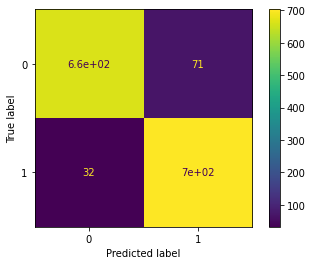

In [96]:
%%time
cat_features = cat_var

parameters = {
    "n_estimators": [10, 20, 30],
    "learning_rate": [0.5, 1, 0.01],
    "max_depth": [5,4,6],
}

model_catboost = CatBoostClassifier(
    cat_features = cat_features,
    random_state=42,
    task_type="GPU",
    devices='0:1',
)

model_catboost = GridSearchCV(
    model_catboost, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_catboost.fit(x_train, y_train, eval_set=(x_test, y_test),
             use_best_model=True,
             verbose=False)

print(f'Best parameters {model_catboost.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_catboost.best_score_:.3f}'
)

y_pred = model_catboost.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['False', 'True']))

cm = confusion_matrix(y_test, y_pred, labels=model_catboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_catboost.classes_)
disp.plot()

del y_pred
gc.collect()

In [100]:
model_catboost.best_estimator_.save_model("/content/drive/MyDrive/Модели-предсказатели завершенности тендеров/auction/catboost(isCanseled)")

In [98]:
#значимость признаков для леса
importances = model_catboost.best_estimator_.get_feature_importance()
indices = np.argsort(importances)[::-1]
col = ['plan_number',	'customer_legal_form',	'positionNumber',	'publicDiscussion',	'isEnergyServiceContract',	'time',	'OKPD']
ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признака:")
ar_f.sort(reverse=True)
ar_f

Значимость признака:


[[89.113, 'positionNumber'],
 [5.714, 'plan_number'],
 [1.9724, 'customer_legal_form'],
 [1.6255, 'time'],
 [1.5751, 'OKPD'],
 [0.0, 'publicDiscussion'],
 [0.0, 'isEnergyServiceContract']]